# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import optuna
from optuna.samplers import TPESampler
import shap

# Data + EDA

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.shape

(1460, 21)

In [6]:
train.dtypes

LandContour      object
GarageYrBlt     float64
FullBath          int64
1stFlrSF          int64
BsmtFinSF1        int64
TotRmsAbvGrd      int64
ExterQual        object
OpenPorchSF       int64
Heating          object
Condition2       object
OverallQual       int64
GarageCars        int64
KitchenQual      object
KitchenAbvGr      int64
GrLivArea         int64
2ndFlrSF          int64
CentralAir       object
BsmtQual         object
TotalBsmtSF       int64
Fireplaces        int64
SalePrice         int64
dtype: object

In [7]:
test.shape

(1459, 20)

In [8]:
test.dtypes

LandContour      object
GarageYrBlt     float64
FullBath          int64
1stFlrSF          int64
BsmtFinSF1      float64
TotRmsAbvGrd      int64
ExterQual        object
OpenPorchSF       int64
Heating          object
Condition2       object
OverallQual       int64
GarageCars      float64
KitchenQual      object
KitchenAbvGr      int64
GrLivArea         int64
2ndFlrSF          int64
CentralAir       object
BsmtQual         object
TotalBsmtSF     float64
Fireplaces        int64
dtype: object

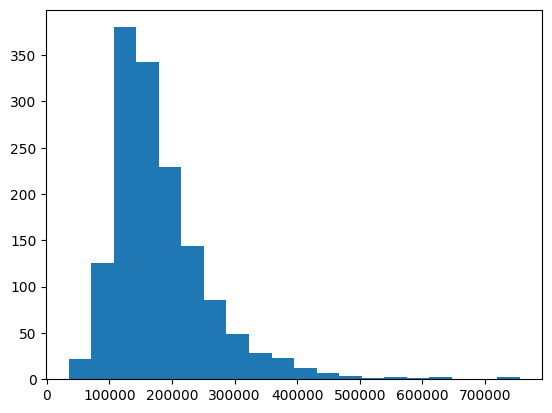

In [9]:
plt.hist(train['SalePrice'], bins=20)
plt.show()

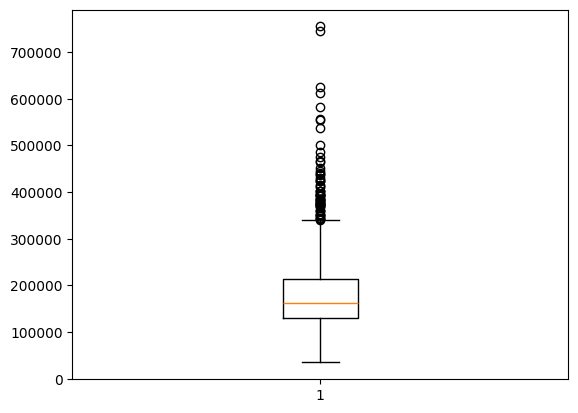

In [10]:
plt.boxplot(train['SalePrice'])
plt.show()

Чтобы сделать распределение целевой переменной более близким к нормальному я возьму ее логарифм и буду предсказывать именно его. На графике ниже видна разница.

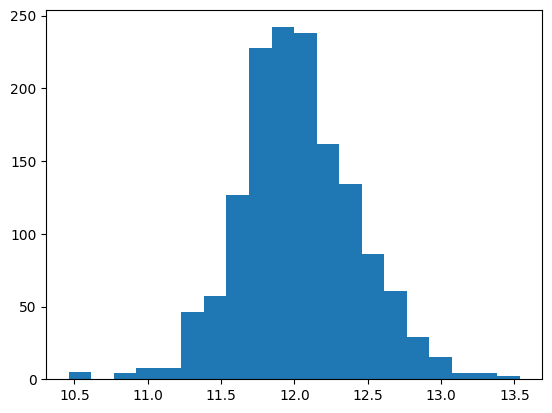

In [11]:
plt.hist(np.log(train['SalePrice']), bins=20)
plt.show()

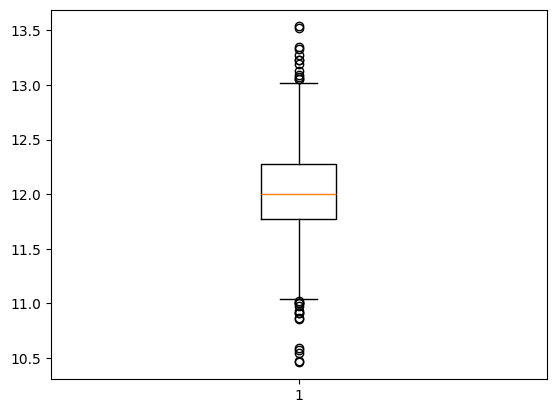

In [12]:
plt.boxplot(np.log(train['SalePrice']))
plt.show()

# Preprocessing
Сделаю стриговые колонки категориальными, так как в используемом далее lightgbm есть встроенная поддержка категориальных признаков. А пропущенные значения заполню либо средним, либо 'NoInfo'. Также в test датафрейме есть еще пару колонок с 1-2 пропущенными значениями но я не буду их заполнять, потому что для бустинга это в целом не критично.

In [15]:
def preprocess(df):
    df['LandContour'] = df['LandContour'].astype('category')
    df['ExterQual'] = df['ExterQual'].astype('category')
    df['Heating'] = df['Heating'].astype('category')
    df['Condition2'] = df['Condition2'].astype('category')
    df['KitchenQual'] = df['KitchenQual'].astype('category')
    df['CentralAir'] = df['CentralAir'].astype('category')
    df['BsmtQual'] = df['BsmtQual'].astype('category')
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean().round())
    df['BsmtQual'] = df['BsmtQual'].cat.add_categories('NoInfo')
    df['BsmtQual'].fillna('NoInfo',inplace=True)
    
preprocess(train)
preprocess(test)
X = train.drop('SalePrice', axis=1)
y = np.log(train['SalePrice']) # Берем логарифм для нормализации

# Baseline model
Беру KFold с 5 сплитами, делаю кросс-валидацию в каждой итерации при помощи метрики RMSE, а затем усредняю ее для получения оценки модели.

In [17]:
cv = KFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X, y)
scores = list()
model = LGBMRegressor(objective='regression', device='gpu', verbosity=-1)
for train_idx, val_idx in cv_splits:
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    model.fit(X_train_fold, y_train_fold)
    y_val_pred = model.predict(X_val_fold)
    mse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    scores.append(mse)
np.mean(scores)

0.1508548265224508

# Hyperparameters tuning
Использую optuna для выбора гиперпараметров на основе SOTA алгоритма. TPESampler настроен на то, чтобы сначала попробовать случайную оптимизацию для первых 30 испытаний, а затем выполнить байесовский поиск TPE. Я также использую multivariate=True (добавленный в v2.2.0 в качестве экспериментальной функции), который, как сообщается, превосходит независимый TPE.

In [24]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 1000, 2300),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 10000, 65000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 12)
    }
    
    cv = KFold(5, shuffle=True, random_state=0)
    cv_splits = cv.split(X, y)
    scores = list()
    model = LGBMRegressor(**params, random_state=0, objective='regression', device='gpu', verbosity=-1)    
    for train_idx, val_idx in cv_splits:
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        scores.append(rmse)
    
    return np.mean(scores)

sqlite_db = "sqlite:///study.db"
study_name = "lgbm"
optimize = True
if optimize:
    study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                                sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0),
                                direction="minimize", load_if_exists=True)

    study.optimize(objective, n_trials=100)
    print(f"best optimized rmse: {study.best_value:0.5f}")
    print(f"best hyperparameters: {study.best_params}")

    lgbm_params = study.best_params

c:\Python\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-05-09 00:31:34,018] A new study created in RDB with name: lgbm
[I 2024-05-09 00:31:39,095] Trial 0 finished with value: 0.15798582675881823 and parameters: {'num_leaves': 1714, 'learning_rate': 0.09347271781114277, 'n_estimators': 843, 'subsample_for_bin': 39969, 'min_child_samples': 45, 'reg_alpha': 0.0028770084050677926, 'reg_lambda': 2.3761404778025532e-05, 'colsample_bytree': 0.8350638004692479, 'subsample': 0.9727470703757719, 'max_depth': 6}. Best is trial 0 with value: 0.15798582675881823.
[I 2024-05-09 00:31:52,871] Trial 1 finished with value: 0.15193289698476495 and parameters: {'num_leaves': 2030, 'learning_rate': 0.04359384414758623, 'n_estimators': 811, 'subsample_for_bin': 60908, 'min_child_samples': 11, 'reg_alpha': 7.435205853060191e-09, 'reg_lambda': 1.5928833561691813e

best optimized rmse: 0.14293
best hyperparameters: {'num_leaves': 1373, 'learning_rate': 0.01758288867111114, 'n_estimators': 866, 'subsample_for_bin': 21206, 'min_child_samples': 9, 'reg_alpha': 1.0211818189560998e-05, 'reg_lambda': 0.001047818733442906, 'colsample_bytree': 0.41765024403475876, 'subsample': 0.9266370561625568, 'max_depth': 5}


In [36]:
model = LGBMRegressor(**lgbm_params, random_state=0, objective='regression', device='gpu', verbosity=-1)
model.fit(X, y)

LGBMRegressor(colsample_bytree=0.41765024403475876, device='gpu',
              learning_rate=0.01758288867111114, max_depth=5,
              min_child_samples=9, n_estimators=866, num_leaves=1373,
              objective='regression', random_state=0,
              reg_alpha=1.0211818189560998e-05, reg_lambda=0.001047818733442906,
              subsample=0.9266370561625568, subsample_for_bin=21206,
              verbosity=-1)

# Post hoc анализ 
При помощи shap смотрю важность фич в датасете. Оказывается две из них можно было в целом выкинуть, ну ладно)

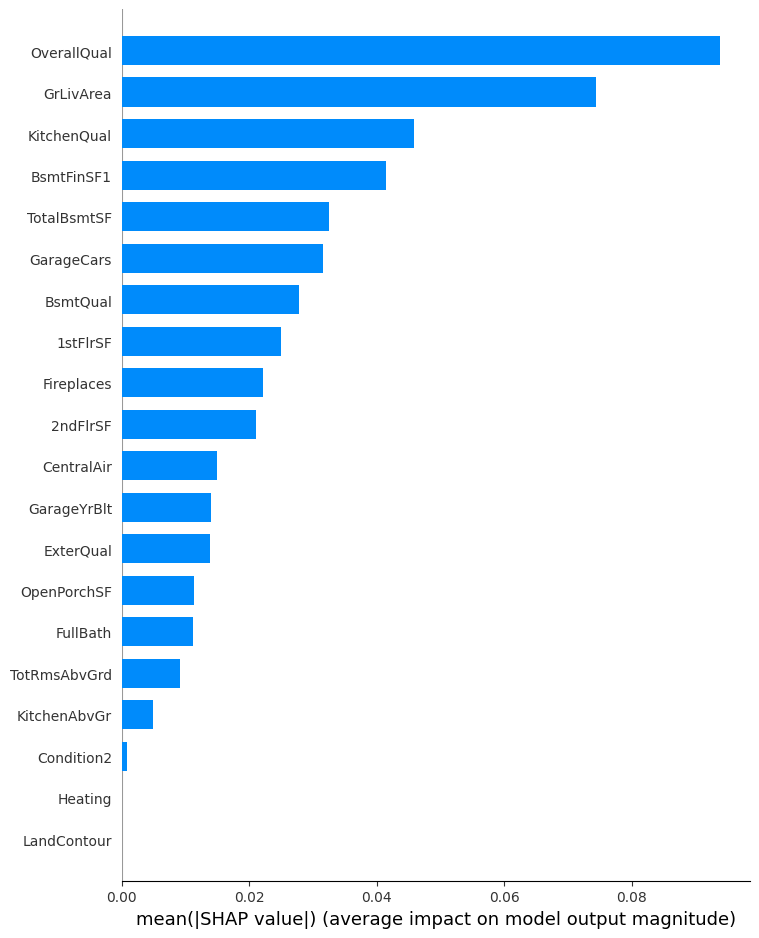

In [37]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar", max_display=50, show=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Submission
Не буду усреднять снова при помощи KFold или делать ансамбль, просто получу предсказания сразу.

In [38]:
submission = pd.read_csv('sample_submission.csv')
preds = model.predict(test)
submission['SalePrice'] = np.exp(preds) # Возвращаем в исходный масштаб
submission.head(10)

,Id,SalePrice
0,1461,123493.265399
1,1462,155543.803869
2,1463,173511.989897
3,1464,170781.903099
4,1465,195094.374675
5,1466,174834.735676
6,1467,161949.353493
7,1468,170721.459201
8,1469,179104.391313
9,1470,119463.535706
